## 3.6. softmax回归的从零开始实现
这一节我们来动手实现softmax回归。首先导入本节实现所需的包或模块。

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
%matplotlib inline

### 3.6.1. 读取数据集
我们将使用Fashion-MNIST数据集，并设置批量大小为256。

In [2]:
batch_size = 256

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = tf.cast(train_images, dtype=tf.float32)/255 #在进行矩阵相乘时需要float型，故强制类型转换为float型
test_images = tf.cast(test_images, dtype=tf.float32)/255
train_iter = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).batch(batch_size)
test_iter = tf.data.Dataset.from_tensor_slices((test_images,test_labels)).batch(batch_size)

### 3.6.2 初始化模型参数

跟线性回归中的例子一样，我们将使用向量表示每个样本。已知每个样本输入是高和宽均为`28`像素的图像。模型的输入向量的长度是 `28×28=78428×28=784`：该向量的每个元素对应图像中每个像素。由于图像有10个类别，单层神经网络输出层的输出个数为10，因此softmax回归的权重和偏差参数分别为`784×10784×10和1×101×10`的矩阵。`Variable`来标注需要记录梯度的向量。

In [3]:
num_inputs = 28*28
num_outputs = 10

W = tf.Variable(tf.random.normal(shape=(num_inputs,num_outputs),stddev=0.01))
b = tf.Variable(tf.zeros(shape=(num_outputs,)))

### 3.6.3. 实现softmax运算
在介绍如何定义 softmax 回归之前，我们先描述一下对如何对多维`Tensor`按维度操作。在下面的例子中，给定一个`Tensor`矩阵`X`。我们可以只对其中同一列（`axis=0`）或同一行（`axis=1`）的元素求和，并在结果中保留行和列这两个维度（`keepdims=True`）。

In [4]:
X = tf.constant([[1, 2, 3], [4, 5, 6]])
tf.reduce_sum(X,axis=0), tf.reduce_sum(X,axis=1), tf.reduce_sum(X,axis=1,keepdims=True)

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([5, 7, 9], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 6, 15], dtype=int32)>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[ 6],
        [15]], dtype=int32)>)

下面我们就可以定义前面小节里介绍的softmax运算了。在下面的函数中，矩阵`X`的行数是样本数，列数是输出个数。为了表达样本预测各个输出的概率，softmax运算会先通过`exp`函数对每个元素做指数运算，再对`exp`矩阵同行元素求和，最后令矩阵每行各元素与该行元素之和相除。这样一来，最终得到的矩阵每行元素和为1且非负。因此，该矩阵每行都是合法的概率分布。softmax运算的输出矩阵中的任意一行元素代表了一个样本在各个输出类别上的预测概率。

In [5]:
def softmax(X):
    '''
        X: tf matrix
    '''
    return tf.exp(X)/tf.reduce_sum(tf.exp(X),axis=1,keepdims=True)

可以看到，对于随机输入，我们将每个元素变成了非负数，且每一行和为1。

In [6]:
X = tf.random.normal(shape=(2,5))
X_prob = softmax(X)
X_prob, tf.reduce_sum(X_prob,axis=1)

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.08622072, 0.14596955, 0.22543104, 0.45898274, 0.08339594],
        [0.11335642, 0.25792173, 0.50040823, 0.05086433, 0.07744928]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.        , 0.99999994], dtype=float32)>)

### 3.6.4. 定义模型
有了softmax运算，我们可以定义上节描述的softmax回归模型了。这里通过`reshape`函数将每张原始图像改成长度为`num_inputs`的向量。

In [7]:
def net(X):
    return softmax(tf.matmul(tf.reshape(X,shape=(-1,num_inputs)),W)+b)

### 3.6.5. 定义损失函数
上一节中，我们介绍了softmax回归使用的交叉熵损失函数。为了得到标签的预测概率，我们可以使用`boolean_mask`函数和`one_hot`函数。在下面的例子中，变量y_hat是2个样本在3个类别的预测概率，变量y是这2个样本的标签类别。通过使用两个函数，我们得到了2个样本的标签的预测概率。与“softmax回归”一节数学表述中标签类别离散值从1开始逐一递增不同，在代码中，标签类别的离散值是从0开始逐一递增的。

In [8]:
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0,2])
tf.boolean_mask(y_hat,tf.one_hot(y,depth=3))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.5], dtype=float32)>

下面实现了3.4节（softmax回归）中介绍的交叉熵损失函数。（注：由于在 Tensorflow 涉及运算类型转换的问题，使用cast函数对张量进行类型转换。）

In [9]:
def cross_entropy(y_hat, y):
    y_hat = tf.cast(y_hat,dtype=tf.float32)
    y = tf.one_hot(y,depth=y_hat.shape[-1])
    return -tf.math.log(tf.boolean_mask(y_hat,y))

### 3.6.6 计算分类准确率
给定一个类别的预测概率分布`y_hat`，我们把预测概率最大的类别作为输出类别。如果它与真实类别`y`一致，说明这次预测是正确的。分类准确率即正确预测数量与总预测数量之比。

为了演示准确率的计算，下面定义准确率`accuracy`函数。其中`tf.argmax(y_hat, axis=1)`返回矩阵`y_hat`每行中最大元素的索引，且返回结果与变量y形状相同。相等条件判断式(`tf.argmax(y_hat, axis=1) == y`)是一个数据类型为bool的Tensor，实际取值为：0（相等为假）或 1（相等为真）。

In [10]:
def accuracy(y_hat,y):
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_hat,axis=1),tf.cast(y,dtype=tf.int64)),dtype=tf.float32))

让我们继续使用在演示boolean_mask函数时定义的变量y_hat和y，并将它们分别作为预测概率分布和标签。可以看到，第一个样本预测类别为2（该行最大元素0.6在本行的索引为2），与真实标签0不一致；第二个样本预测类别为2（该行最大元素0.5在本行的索引为2），与真实标签2一致。因此，这两个样本上的分类准确率为0.5。

In [11]:
accuracy(y_hat,y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

类似地，我们可以评价模型`net`在数据集`data_iter`上的准确率。

In [12]:
# 描述,对于tensorflow2中，比较的双方必须类型都是int型，所以要将输出和标签都转为int型
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for _, (X, y) in enumerate(data_iter):
        y = tf.cast(y,dtype=tf.int64)
        acc_sum += np.sum(tf.cast(tf.argmax(net(X), axis=1), dtype=tf.int64) == y)
        n += y.shape[0]
    return acc_sum / n


因为我们随机初始化了模型`net`，所以这个随机模型的准确率应该接近于类别个数 10 的倒数即 0.1。

In [13]:
print(evaluate_accuracy(train_iter, net))

0.07651666666666666


### 3.6.7 训练模型
训练softmax回归的实现跟 `3.2（线性回归的从零开始实现）`一节介绍的线性回归中的实现非常相似。我们同样使用小批量随机梯度下降来优化模型的损失函数。在训练模型时，迭代周期数`num_epochs`和学习率`lr`都是可以调的超参数。改变它们的值可能会得到分类更准确的模型。

In [14]:
num_epochs,lr = 5, 0.03
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X,y in train_iter:
            with tf.GradientTape(persistent=True) as tape:
                y_hat = net(X)
                l = tf.reduce_sum(loss(y_hat,y))
            grads = tape.gradient(l,params)
            if trainer is None:
                # 如果没有传入优化器，则使用原先编写的小批量随机梯度下降
                for i, param in enumerate(params):
                    param.assign_sub(lr*grads[i]/batch_size)
            else:
                # tf.keras.optimizers.SGD 直接使用是随机梯度下降 theta(t+1) = theta(t) - learning_rate * gradient
                # 这里使用批量梯度下降，需要对梯度除以 batch_size, 对应原书代码的 trainer.step(batch_size)
                trainer.apply_gradients(zip([grad/batch_size for grad in grads], params))
            
            y = tf.cast(y,dtype=tf.float32)
            train_l_sum += l.numpy()
            train_acc_sum += tf.reduce_sum(tf.cast(tf.argmax(y_hat,axis=1)==tf.cast(y,dtype=tf.int64),dtype=tf.int64)).numpy()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'% (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
    
trainer = tf.keras.optimizers.SGD(lr)
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr,trainer)

Instructions for updating:
Use tf.identity instead.
epoch 1, loss 1.0312, train acc 0.702, test acc 0.746
epoch 2, loss 0.7083, train acc 0.778, test acc 0.778
epoch 3, loss 0.6366, train acc 0.799, test acc 0.792
epoch 4, loss 0.5974, train acc 0.809, test acc 0.801
epoch 5, loss 0.5716, train acc 0.816, test acc 0.807


### 3.6.8. 预测
训练完成后，现在就可以演示如何对图像进行分类了。给定一系列图像（第三行图像输出），我们比较一下它们的真实标签（第一行文本输出）和模型预测结果（第二行文本输出）。

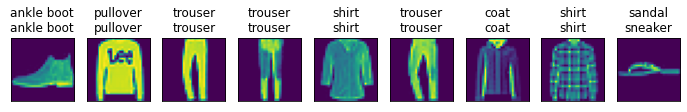

In [15]:
X, y = iter(test_iter).next()

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images, labels):
    # 这⾥的_表示我们忽略（不使⽤）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12)) # 这里注意subplot 和subplots 的区别
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(tf.reshape(img, shape=(28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(tf.argmax(net(X), axis=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[0:9], titles[0:9])

### 小结
- 可以使用softmax回归做多类别分类。与训练线性回归相比，你会发现训练softmax回归的步骤和它非常相似：获取并读取数据、定义模型和损失函数并使用优化算法训练模型。事实上，绝大多数深度学习模型的训练都有着类似的步骤。